In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import skimage.morphology
import skimage.measure
import skimage.segmentation
import skimage.feature
import sklearn.preprocessing
import imageio
import glob
import cv2
from scipy.spatial import distance as dist
import pyefd
import math
import sklearn.decomposition
from __future__ import print_function
from __future__ import division
import cv2 as cv
import numpy as np
import argparse
from math import atan2, cos, sin, sqrt, pi
from sklearn.svm import *
import sklearn.feature_selection
import sklearn.metrics
import scipy.io as spio

In [2]:
#------Rotation from OpenCV tutorial-----------
def getOrientation(pts, img):
    
    sz = len(pts)
    data_pts = np.empty((sz, 2), dtype=np.float64)
    for i in range(data_pts.shape[0]):
        data_pts[i,0] = pts[i,0,0]
        data_pts[i,1] = pts[i,0,1]
    # Perform PCA analysis
    mean = np.empty((0))
    mean, eigenvectors, eigenvalues = cv.PCACompute2(data_pts, mean)
    # Store the center of the object
    cntr = (int(mean[0,0]), int(mean[0,1]))
    
    
    cv.circle(img, cntr, 3, (255, 0, 255), 2)
    p1 = (cntr[0] + 0.02 * eigenvectors[0,0] * eigenvalues[0,0], cntr[1] + 0.02 * eigenvectors[0,1] * eigenvalues[0,0])
    p2 = (cntr[0] - 0.02 * eigenvectors[1,0] * eigenvalues[1,0], cntr[1] - 0.02 * eigenvectors[1,1] * eigenvalues[1,0])
    angle = atan2(eigenvectors[0,1], eigenvectors[0,0]) # orientation in radians
    
    return angle

In [3]:
def image_preprocessing(filepath):
    img = imageio.imread(filepath)
    M = np.shape(img)[1]
    
    if M == 640:
        temp_mask = np.where(imageio.imread('masks\\small_mask.tiff')==1, True, False)
    if M == 848:
        temp_mask = np.where(imageio.imread('masks\\big_mask.tiff')==1, True, False)
    img = img*temp_mask
    # plt.imshow(img)
    # plt.title('img')
    
    otsu_thresh = skimage.filters.threshold_otsu(img[temp_mask])
    img_post = np.where(img<otsu_thresh, img, 0)
    img_post = skimage.morphology.opening(img_post, skimage.morphology.disk(10))
    #plt.figure()
    #plt.imshow(img_post)
    img_mask = np.where(img_post != 0, 1, 0)
    #img_seg = skimage.segmentation.slic(img_post, n_segments=3, compactness=0.001, sigma=0, enforce_connectivity=False, min_size_factor=0.5, mask=temp_mask)

    # plt.figure()
    # plt.imshow(slic_seg)
    # plt.title('slic_seg')

    # plt.figure()
    # plt.imshow(slic_seg*np.where(img_post !=0, 1, 0))
    # plt.title('modified slic')
    #img_post = skimage.morphology.remove_small_objects(img_post, 64)
    #img_post = skimage.morphology.opening(img_post, skimage.morphology.disk(5))
    #img_post = skimage.morphology.closing(img_post, skimage.morphology.disk(10))
    

    #img_mask = np.where(img_post != 0, 1, 0)
    #otsu_thresh = skimage.filters.threshold_otsu(img_post[temp_mask])
    #plt.figure()
    #plt.hist(img_post[temp_mask].flatten(), bins = 1250)
    # img_post_new = np.where(img_post<otsu_thresh, img, 0)
    #img_mask = np.where(1200 < img <1400, 1, 0)
    
    # plt.figure()
    # plt.imshow(img_mask)
    # plt.title('img_mask')
    
    #Segment the image
    img_seg = skimage.measure.label(img_mask, background = 0, connectivity=2)
    # plt.figure()
    # plt.imshow(img_seg)
    # plt.title('img_seg')

    
    #Find largest segment
    max_size = 0
    layer = []
    for i in range(1, np.max(img_seg)+1):
        max_temp = np.sum(np.where(img_seg == i, 1, 0))
        if max_temp > max_size:
            max_size = max_temp
            layer.append(i)
    #print(len(layer))

    largest_seg = np.where(img_seg == layer[-1], True, False)
    #print(np.average(np.where(img_seg == layer[-1], img, 0)))
    #print(np.average(np.where(img_seg == layer[-2], img, 0)))
    # print(np.average(largest_seg))
    # print(type(largest_seg[0,0]))
    if np.average(largest_seg[temp_mask]) < 100:
        try:
            largest_seg = np.where(img_seg == layer[-2], True, False)
        except:
            pass
    # plt.figure()
    # plt.imshow(largest_seg)
    
    #Get image orientation
    cow_mask = np.where(largest_seg == True, 255, 0).astype('uint8')
    #plt.figure()
    #plt.imshow(cow_mask)
    
    
    src = cow_mask
    contours, _ = cv.findContours(src, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
    for i, c in enumerate(contours):
        angle = getOrientation(c, src)
        angle = np.rad2deg(angle)-90
        if angle < -180:
            angle = angle+180


    image_center = tuple(np.array(cow_mask.shape[1::-1]) / 2)
    #rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    #rotated_cow = cv2.warpAffine(cow_mask, rot_mat, cow_mask.shape[1::-1], flags=cv2.INTER_LINEAR)
    

    
    #crop the new image to be flat on top
    for i in range(np.shape(cow_mask)[0]):
        if np.sum(cow_mask[i, :]) != 0:
            len_top_row = int(np.sum(cow_mask[i, :])/255)
            break

    crop_length = abs(int(len_top_row*np.tan(abs(np.deg2rad(angle)))))
    
    
    #cnt, _ = cv2.findContours(rotated_cow, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) #use when rotating image
    cnt, _ = cv2.findContours(cow_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    max_cnt = max(cnt, key=cv2.contourArea)


    reshaped_contour = np.asarray(max_cnt).reshape((np.shape(max_cnt)[0], 2))

    max_y_crop = np.max(reshaped_contour[::, 0])
    min_y_crop = np.min(reshaped_contour[::, 0])


    max_x_crop = np.max(reshaped_contour[::, 1])
    min_x_crop = crop_length


    # if min_x_crop > 10: #use when rotating
    #     cropped_cow = rotated_cow[min_x_crop-10:max_x_crop+10, min_y_crop-10:max_y_crop+10]
    # if min_x_crop < 10:
    #     cropped_cow = rotated_cow[min_x_crop:max_x_crop+10, min_y_crop-10:max_y_crop+10]

    if min_x_crop > 20:
        cropped_cow = cow_mask[min_x_crop-20:max_x_crop+20, min_y_crop-20:max_y_crop+20]
    if min_x_crop <= 20:
        cropped_cow = cow_mask[min_x_crop:max_x_crop+20, min_y_crop-20:max_y_crop+20]
    cnt, _ = cv2.findContours(cropped_cow, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    max_cnt = max(cnt, key=cv2.contourArea)
    reshaped_contour = np.asarray(max_cnt).reshape((np.shape(max_cnt)[0], 2))

    b_cow = np.where(cropped_cow>0, 1, 0)
    
    #Rotating the depth image to be the same as the mask
    #depth = imageio.imread(img_names[img_num])
    # rotated_depth = cv2.warpAffine(img, rot_mat, img.shape[1::-1], flags=cv2.INTER_LINEAR) #use when rotating

    # if min_x_crop > 10:
    #     cropped_depth = rotated_depth[min_x_crop-10:max_x_crop+10, min_y_crop-10:max_y_crop+10]
    # if min_x_crop < 10:
    #     cropped_depth = rotated_depth[min_x_crop:max_x_crop+10, min_y_crop-10:max_y_crop+10]
    
    if min_x_crop > 20:
        cropped_depth = img[min_x_crop-20:max_x_crop+20, min_y_crop-20:max_y_crop+20]
    if min_x_crop <= 20:
        cropped_depth = img[min_x_crop:max_x_crop+20, min_y_crop-20:max_y_crop+20]
        
    masked_depth = (b_cow*cropped_depth).astype('uint16')

    otsu_thresh = skimage.filters.threshold_otsu(masked_depth[np.where(b_cow !=0, True, False)])
    depth_to_be_masked = np.where(masked_depth<(otsu_thresh+60), masked_depth, 0)
    
    mask_to_seg = np.where(depth_to_be_masked !=0, 1, 0)
    seg_mask = skimage.measure.label(mask_to_seg, background = 0, connectivity=2)

    max_size = 0
    layer = []
    for i in range(1, np.max(seg_mask)+1):
        max_temp = np.sum(np.where(seg_mask == i, 1, 0))
        if max_temp > max_size:
            max_size = max_temp
            layer.append(i)


    largest_seg = np.where(seg_mask == layer[-1], True, False)
    if np.average(largest_seg[np.where(mask_to_seg==1, True, False)]) < 100:
        try:
            largest_seg = np.where(img_seg == layer[-2], True, False)
        except:
            pass
    final_mask = np.where(largest_seg != 0, 1, 0)
    final_depth = np.where(final_mask != 0, depth_to_be_masked, 0)




    
    
#     plt.figure(figsize=(10,10))
#     plt.imshow(img, cmap='gray')
#     plt.axis('off')
#     plt.title('Original Image')

#     plt.figure(figsize=(10,10))
#     plt.imshow(cow_mask, cmap='gray')
#     plt.axis('off')
#     plt.title('Largest Object')
    
#     plt.figure(figsize=(10,10))
#     plt.imshow(rotated_cow, cmap='gray')
#     plt.axis('off')
#     plt.title('Rotated Image')
    
#     plt.figure(figsize=(7,7))
#     plt.imshow(masked_depth, cmap='gray')
#     plt.axis('off')
#     plt.title('Processed Image')
    
    
    return final_depth, final_mask

Text(0.5, 1.0, 'Mask')

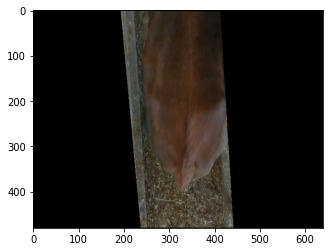

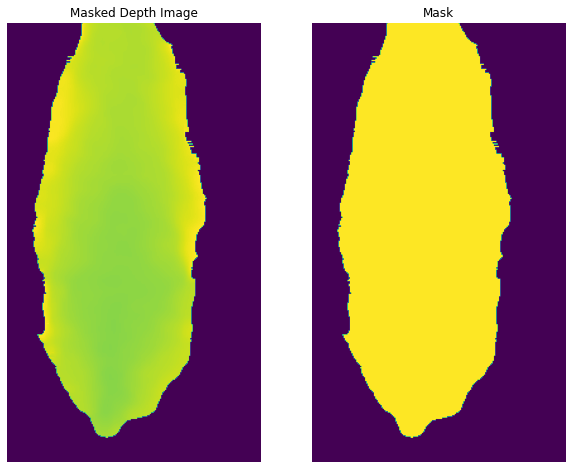

In [4]:
img_num = 1
filenames_temp = glob.glob('BCS_sorted\\3\\Cow_42\\*')

temp_mask = imageio.imread('masks\\big_mask.tiff')


filenames = []
filenames_rgb = []
for image in filenames_temp:
    if image.endswith('_D.tif'):
        filenames.append(image)
    if image.endswith('_C.tif'):
        filenames_rgb.append(image)

# img = imageio.imread(filenames[img_num])
# img_rgb = imageio.imread(filenames_rgb[img_num])

test_img_name = 'BCS_sorted\\6\\Cow_18\\144'
img = imageio.imread(test_img_name+'_D.tif')
img_rgb = imageio.imread(test_img_name+'_C.tif')
masked_depth, mask = image_preprocessing(test_img_name+'_D.tif')


# masked_depth, mask = image_preprocessing(filenames[img_num])


plt.figure()
img_rgb[:, :, 0] = img_rgb[:, :, 0]*temp_mask[:, int((848-640)/2):int((848-(848-640)/2))]
img_rgb[:, :, 1] = img_rgb[:, :, 1]*temp_mask[:, int((848-640)/2):int((848-(848-640)/2))]
img_rgb[:, :, 2] = img_rgb[:, :, 2]*temp_mask[:, int((848-640)/2):int((848-(848-640)/2))]
plt.imshow(img_rgb)

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(masked_depth)
plt.axis('off')
plt.title('Masked Depth Image')

plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.axis('off')
plt.title('Mask')

[-4117017.63310125 -4059302.36863516 -3903503.13615147 -3479244.83163498
 -3153520.15955827 -2322242.98666869 -1232957.8807593    237454.31264359
  2585077.42041607  5302486.65256519  7105671.97995715  8399214.47281104
  9022072.42290998  5921400.55350835  3158564.78050598  1055287.82782987
  -639018.59518622 -1818746.79660386 -2748064.61273353 -3402065.16181478
 -3804395.89006744 -4019295.72968561 -4087854.64054667] ['PCA_0', 'PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5', 'PCA_6', 'PCA_7', 'PCA_8', 'PCA_9', 'PCA_10', 'PCA_11', 'PCA_12', 'PCA_13', 'PCA_14', 'PCA_15', 'PCA_16', 'PCA_17', 'PCA_18', 'PCA_19', 'PCA_20', 'PCA_21', 'PCA_22']
(23,)


Text(0.5, 1.0, 'Kernel PCA')

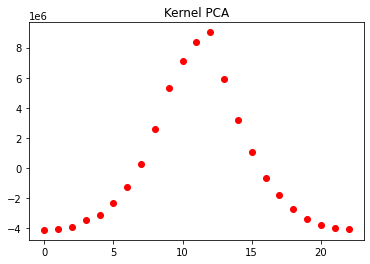

In [5]:
#----------------------Getting Kernel PCA---------------------------------
def extract_kernel_PCA(mask):
    B=skimage.measure.find_contours(mask,0.5,'high')[0]
    #print(np.shape(B))
    factor = int(np.shape(B)[0]/23)
    rem = np.shape(B)[0]%factor
    len_B = np.shape(B)[0]
    
    B_23 = np.zeros((23, 2))
    #print(B)
    #print(B_23)
    #print(np.shape(B_23))
    Big_B_0 = B[0:(len_B-rem):factor, 0]
    Big_B_1 = B[0:(len_B-rem):factor, 1]
    if len(Big_B_0) > 23:
        Big_B_0 = Big_B_0[0:23]
        Big_B_1 = Big_B_1[0:23]


    #B_23[:, 0] = B[0:(len_B-rem):factor, 0]
    #B_23[:, 1] = B[0:(len_B-rem):factor, 1]
    B_23[:, 0] = Big_B_0
    B_23[:, 1] = Big_B_1
    #print(B_23)
    kpca = sklearn.decomposition.KernelPCA(n_components = 1, kernel = 'poly')
    f = kpca.fit_transform(B_23).T[0]
    fnames = []
    for i in range(0, 23):
        fnames.append(f'PCA_{i}')

    
    return f, fnames

f, fnames = extract_kernel_PCA(mask)
print(f, fnames)
print(np.shape(f))

plt.figure()
plt.plot(f, 'ro')
plt.title('Kernel PCA')

Text(0.5, 1.0, 'Fourier Descriptors')

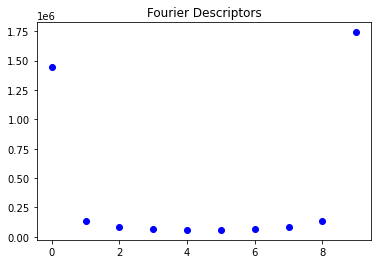

In [6]:
#------------------------Getting fourier descriptors-----------------------

def extract_boundary_features(mask):
  f = np.arange(0, 10)
  fnames = []
  fnames.append('Fourier_desc_a0')
  fnames.append('Fourier_desc_a1')
  fnames.append('Fourier_desc_a2')
  fnames.append('Fourier_desc_a3')
  fnames.append('Fourier_desc_a4')
  fnames.append('Fourier_desc_a5')
  fnames.append('Fourier_desc_a6')
  fnames.append('Fourier_desc_a7')
  fnames.append('Fourier_desc_a8')
  fnames.append('Fourier_desc_a9')

  B=skimage.measure.find_contours(mask,0.5,'high')[0]

  s = np.zeros(np.shape(B)[0], dtype=complex)
  for k in range(np.shape(B)[0]):
    s[k] = float(B[k][0]) + float(B[k][1])*1j
  
  S = scipy.fft.fft(s, n=10000)
  # print(s[1])
  # print(type(s[1]))
  for k in range(0,10):
    f[k] = np.abs(S[k*1000:(k+1)*1000].sum())
  return f, fnames


FD, fnames = extract_boundary_features(mask)

plt.figure()
plt.plot(FD, 'bo')
plt.title('Fourier Descriptors')

[2.35413763e-01 2.98422089e-02 6.58630944e-06 2.12392589e-06
 7.92017355e-12 3.65852401e-07 6.12644468e-13]


Text(0.5, 1.0, 'Hu Moments')

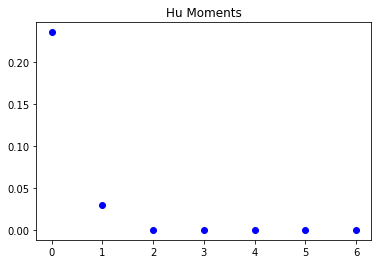

In [7]:
#----Hu Moments--------
def extract_hu_moments(mask):
    props = skimage.measure.regionprops(np.where(mask>0, 1, 0), cache=True)
    fnames = ['phi1', 'phi2', 'phi3', 'phi4', 'phi5', 'phi6', 'phi7']
    f = props[0].moments_hu
    return f, fnames


f, fnames = extract_hu_moments(mask)
print(f)

plt.figure()
plt.plot(f, 'bo')
plt.title('Hu Moments')

In [8]:
def regionprops_features(mask):
  props = skimage.measure.regionprops(mask.astype(int))
  fnames = ['area', 'convex_area', 'eccentricity','equivalent_diameter', 'euler_number', 'extent', 'filled_area','major_axis_length', 'minor_axis_length', 'perimeter', 'solidity']
  f = [props[0]['area'], props[0]['convex_area'], props[0]['eccentricity'], props[0]['equivalent_diameter'], props[0]['euler_number'], props[0]['extent'], props[0]['filled_area'],
       props[0]['major_axis_length'], props[0]['minor_axis_length'], props[0]['perimeter'], props[0]['solidity']]
  return f, fnames

f, fnames = regionprops_features(mask)
print(f, fnames)

[33928, 35577, 0.9200386270407939, 207.8424193319896, 1, 0.747279855512973, 33928, 332.84405280244863, 130.41751043695228, 873.4823227814084, 0.9536498299463136] ['area', 'convex_area', 'eccentricity', 'equivalent_diameter', 'euler_number', 'extent', 'filled_area', 'major_axis_length', 'minor_axis_length', 'perimeter', 'solidity']


(array([ 83,  86,  91,  92,  93, 266], dtype=int64),)


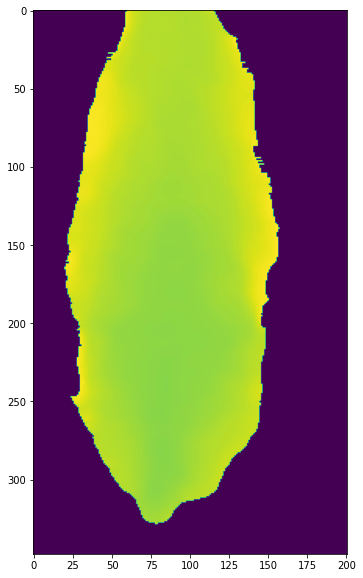

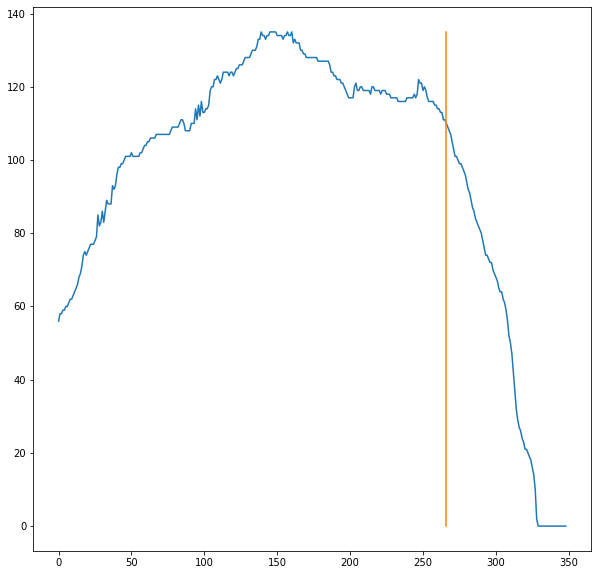

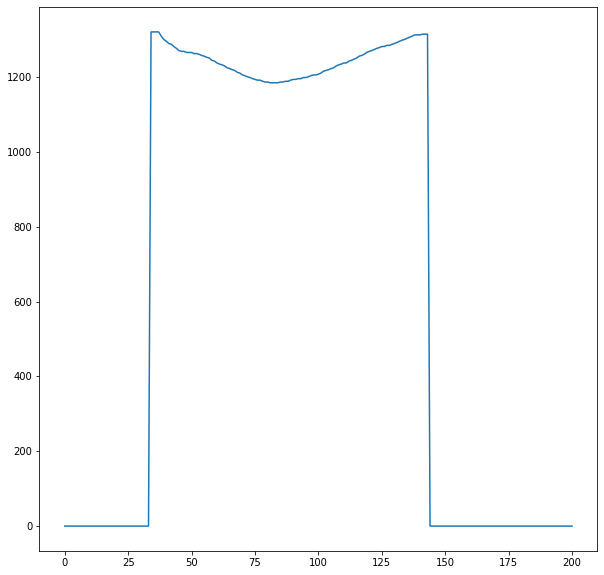

In [9]:
#Scanning the body to locate the hips

row_sums = np.sum(mask, axis=1)
if (len(row_sums)%2 == 0):
    row_sums = np.append(row_sums, 0, axis=None)
    

hip_loc = np.where(row_sums == int(np.median(row_sums)))
print((hip_loc))
if np.shape(hip_loc) != ():
    hip_loc = hip_loc[0][-1]
    

length_depth, width_depth = np.shape(masked_depth)


plt.figure(figsize=(10,10))
plt.imshow(masked_depth, cmap='gray')
masked_line = np.zeros(np.shape(mask))
masked_line[hip_loc, 0:width_depth] = np.max(mask)
plt.imshow(masked_line+masked_depth)


plt.figure(figsize=(10,10))
plt.plot(np.arange(0, len(row_sums)), row_sums)
plt.plot([hip_loc, hip_loc], [0, np.max(row_sums)])

plt.figure(figsize=(10,10))
plt.plot(masked_depth[hip_loc, 0:width_depth])


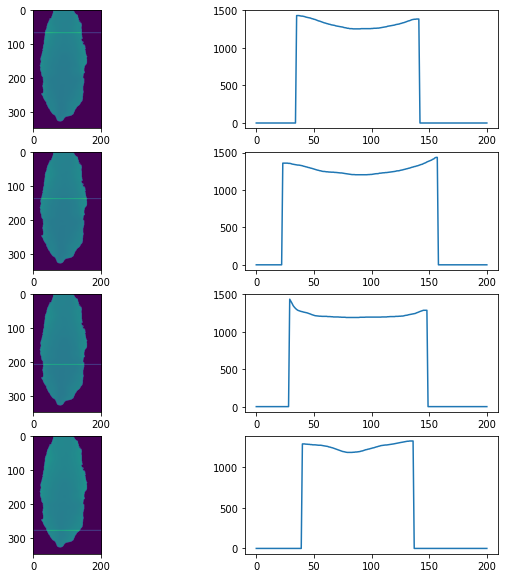

In [10]:
slice_vec = [int(length_depth/5), int(2*length_depth/5), int(3*length_depth/5), int(4*length_depth/5), length_depth]
j = 0
plt.figure(figsize=(10,10))
for i in range(1,9, 2):
    plt.subplot(4, 2, i)
    plt.imshow(masked_depth, cmap='gray')
    masked_line = np.zeros(np.shape(masked_depth))
    masked_line[slice_vec[j], 0:width_depth] = np.max(masked_depth)
    plt.imshow(masked_line+masked_depth)
    
    
    plt.subplot(4, 2, i+1)
    plt.plot(masked_depth[slice_vec[j], 0:width_depth])
    j+=1

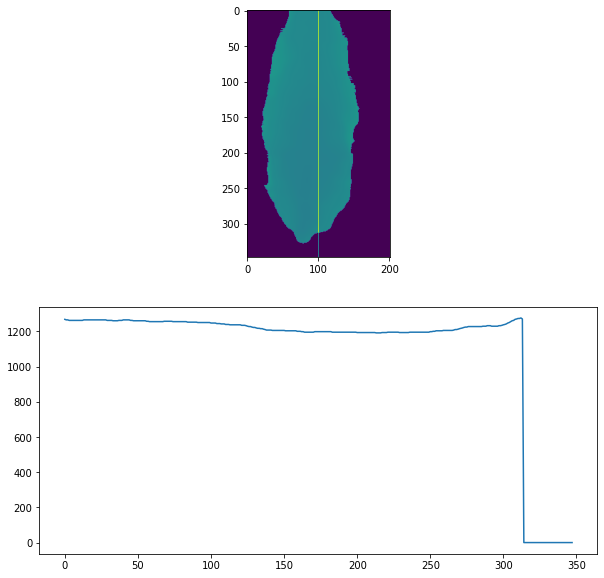

In [11]:
plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)
masked_line = np.zeros(np.shape(masked_depth))
masked_line[0:length_depth, int(width_depth/2)] = np.max(masked_depth)
plt.imshow(masked_line+masked_depth)

plt.subplot(2, 1, 2)
plt.plot(masked_depth[0:length_depth, int(width_depth/2)])

In [12]:
## Getting GLCM features
#from skimage.feature import graycomatrix, graycoprops
import skimage.feature.texture


def extract_texture_features(im, mask):
    im_1 = np.round((im/np.max(im))*31).astype(int)
    
    I_q_masked = im_1*np.where(mask >0 , 1, 0)


    G = skimage.feature.greycomatrix(I_q_masked,distances=(1,2,3,4),angles=(0,np.pi/4,np.pi/2,3*np.pi/4),levels=np.max(I_q_masked)+1,symmetric=True,normed=False)#[0:-1, 0:-1, ::, ::]
    G_temp = np.zeros(np.shape(G))
    for d in range(0,4):
        for t in range(0,4):
            G_temp[:,:,d,t]=G[:,:,d,t]/G[:,:,d,t].sum()


    contrast = skimage.feature.greycoprops(G_temp, prop='contrast')
    d0_contrast_mean = np.mean(contrast[0, ::])
    d1_contrast_mean = np.mean(contrast[1, ::])
    d2_contrast_mean = np.mean(contrast[2, ::])
    d3_contrast_mean = np.mean(contrast[3, ::])
  
    d0_contrast_std = np.std(contrast[0,::])
    d1_contrast_std = np.std(contrast[1,::])
    d2_contrast_std = np.std(contrast[2,::])
    d3_contrast_std = np.std(contrast[3,::])

    correlation = skimage.feature.greycoprops(G_temp, prop='correlation')
    d0_correlation_mean = np.mean(correlation[0, ::])
    d1_correlation_mean = np.mean(correlation[1, ::])
    d2_correlation_mean = np.mean(correlation[2, ::])
    d3_correlation_mean = np.mean(correlation[3, ::])
  
    d0_correlation_std = np.std(correlation[0,::])
    d1_correlation_std = np.std(correlation[1,::])
    d2_correlation_std = np.std(correlation[2,::])
    d3_correlation_std = np.std(correlation[3,::])

    homogeneity = skimage.feature.greycoprops(G_temp, prop='homogeneity')
    d0_homogeneity_mean = np.mean(homogeneity[0, ::])
    d1_homogeneity_mean = np.mean(homogeneity[1, ::])
    d2_homogeneity_mean = np.mean(homogeneity[2, ::])
    d3_homogeneity_mean = np.mean(homogeneity[3, ::])
  
    d0_homogeneity_std = np.std(homogeneity[0,::])
    d1_homogeneity_std = np.std(homogeneity[1,::])
    d2_homogeneity_std = np.std(homogeneity[2,::])
    d3_homogeneity_std = np.std(homogeneity[3,::])

    energy = skimage.feature.greycoprops(G_temp, prop='energy')
    d0_energy_mean = np.mean(energy[0, ::])
    d1_energy_mean = np.mean(energy[1, ::])
    d2_energy_mean = np.mean(energy[2, ::])
    d3_energy_mean = np.mean(energy[3, ::])
  
    d0_energy_std = np.std(energy[0,::])
    d1_energy_std = np.std(energy[1,::])
    d2_energy_std = np.std(energy[2,::])
    d3_energy_std = np.std(energy[3,::])


    f = [d0_contrast_mean, d1_contrast_mean, d2_contrast_mean, d3_contrast_mean, d0_contrast_std, d1_contrast_std, d2_contrast_std, d3_contrast_std,
       d0_correlation_mean, d1_correlation_mean, d2_correlation_mean, d3_correlation_mean, d0_correlation_std, d1_correlation_std, d2_correlation_std, d3_correlation_std,
       d0_homogeneity_mean, d1_homogeneity_mean, d2_homogeneity_mean, d3_homogeneity_mean, d0_homogeneity_std, d1_homogeneity_std, d2_homogeneity_std, d3_homogeneity_std,
       d0_energy_mean, d1_energy_mean, d2_energy_mean, d3_energy_mean, d0_energy_std, d1_energy_std, d2_energy_std, d3_energy_std]

    fnames = ['d0_contrast_mean', 'd1_contrast_mean', 'd2_contrast_mean', 'd3_contrast_mean', 'd0_contrast_std', 'd1_contrast_std', 'd2_contrast_std', 'd3_contrast_std',
       'd0_correlation_mean', 'd1_correlation_mean', 'd2_correlation_mean', 'd3_correlation_mean', 'd0_correlation_std', 'd1_correlation_std', 'd2_correlation_std', 'd3_correlation_std',
       'd0_homogeneity_mean', 'd1_homogeneity_mean', 'd2_homogeneity_mean', 'd3_homogeneity_mean', 'd0_homogeneity_std', 'd1_homogeneity_std', 'd2_homogeneity_std', 'd3_homogeneity_std',
       'd0_energy_mean', 'd1_energy_mean', 'd2_energy_mean', 'd3_energy_mean', 'd0_energy_std', 'd1_energy_std', 'd2_energy_std', 'd3_energy_std']
    return f, fnames


f, fnames = extract_texture_features(masked_depth, mask)
print(f, fnames)

[7.757218141998939, 10.55038505081404, 17.557476931162167, 24.634913489244735, 2.1280945391950614, 3.6233525215312414, 5.2921795143028705, 7.394639828681061, 0.9793931207688988, 0.9719756961496884, 0.9533734954404746, 0.9345888935608182, 0.005651767769792786, 0.009621109401052865, 0.014048618281332975, 0.019625949696389297, 0.9772372914129818, 0.9687920896481094, 0.9478390598872581, 0.9273804830105493, 0.006923579955812214, 0.011325619189193368, 0.016248140581484397, 0.02223444370038195, 0.5557272465138218, 0.5519366318727588, 0.5423120701115816, 0.5329741332119822, 0.003214792525409669, 0.004783840876778438, 0.006840812033967489, 0.009462182565333972] ['d0_contrast_mean', 'd1_contrast_mean', 'd2_contrast_mean', 'd3_contrast_mean', 'd0_contrast_std', 'd1_contrast_std', 'd2_contrast_std', 'd3_contrast_std', 'd0_correlation_mean', 'd1_correlation_mean', 'd2_correlation_mean', 'd3_correlation_mean', 'd0_correlation_std', 'd1_correlation_std', 'd2_correlation_std', 'd3_correlation_std', 'd

In [65]:
def make_X_train(category_filepath):
    category_temp = sorted(glob.glob(category_filepath))

    category = []
    for image in category_temp:
        if image.endswith('_D.tif'):
            category.append(image)
    
    image_train = category[0:int(len(category)*0.9)]
    X_train = np.zeros((int(len(image_train)), 83 ))
    y_train = []
    i = 0
    j = 0

    images_with_errors = []
    for images in range(int(len(image_train))):
        image_path = image_train[images]
        # BCS = int(int(image_path[len('BCS_sorted\0')])/2) #Replace the following two lines with the commented out one ot switch back to 0-9 mode
        # y_train.append(str(BCS))
        y_train.append(image_path[len('BCS_sorted\0')])
        
        
        try:
            depth_mask, mask = image_preprocessing(image_path)

            X_train[images, 0:10]= extract_boundary_features(mask)[0]
            X_train[images, 10:17]= extract_hu_moments(mask)[0]
            X_train[images, 17:28]= regionprops_features(mask)[0]
            X_train[images, 28:60]= extract_texture_features(depth_mask, mask)[0]
            X_train[images, 60:83]= extract_kernel_PCA(mask)[0]
            j+=1
            
        except (UnboundLocalError, ValueError, ZeroDivisionError):
            X_train[images, ::] = 0
            images_with_errors.append(image_path)
            i+=1
    print(i, ' images not used out of,', j, ', ', i/j*100, ' percent.')
    #print(images_with_errors)
    np.savetxt(f"images_with_errors\\{y_train[0]}_train.txt", np.asarray(images_with_errors), delimiter=',', fmt ='%s')
    return X_train, y_train


def make_X_test(category_filepath):
    category_temp = sorted(glob.glob(category_filepath))

    category = []
    for image in category_temp:
        if image.endswith('_D.tif'):
            category.append(image)

    image_test = category[int(len(category)*0.9):int(len(category))]
    X_test = np.zeros(( len(image_test), 83 ))
    y_test = []
    i = 0
    j = 0
    images_with_errors = []

    for images in range(len(image_test)):
        image_path = image_test[images]
        # BCS = int(int(image_path[len('BCS_sorted\0')])/2) #Replace the following two lines with the commented out one ot switch back to 0-9 mode
        # y_test.append(str(BCS))
        y_test.append(image_path[len('BCS_sorted\0')])

        try:
            depth_mask, mask = image_preprocessing(image_path)
            X_test[images, 0:10]= extract_boundary_features(mask)[0]
            X_test[images, 10:17]= extract_hu_moments(mask)[0]
            X_test[images, 17:28]= regionprops_features(mask)[0]
            X_test[images, 28:60]= extract_texture_features(depth_mask, mask)[0]
            X_test[images, 60:83]= extract_kernel_PCA(mask)[0]
            j+=1
        except (UnboundLocalError, ValueError, ZeroDivisionError):
            X_test[images, ::] = 0
            #print(image_path)
            i+=1
            images_with_errors.append(image_path)
    print(i, ' images not used out of ', j, ', ', i/j*100, ' percent.')
    #print(images_with_errors)
    np.savetxt(f"images_with_errors\\{y_test[0]}_test.txt", np.asarray(images_with_errors), delimiter=',', fmt ='%s')
    return X_test, y_test

In [66]:
def normalize_Xtrain(X_train):
    mn = []
    mx = []
    Xn_train = np.zeros(np.shape(X_train))
    X_norm = np.zeros(np.shape(X_train))
    for i in range(len(X_train[0, ::])):
        mn.append(np.min(X_train[::, i]))
        Xn_train[::, i] = X_train[::, i] - mn[i]
    for i in range(len(X_train[0, ::])):
        mx.append(np.max(Xn_train[::, i]))
        if mx[i] == 0:
            X_norm[::, i] = 0
        if mx[i] != 0:
            X_norm[::, i] = Xn_train[::, i]/mx[i]
            
    return X_norm, mx, mn

def normalize_Xtest(X_test, mx, mn):
    Xn_test = np.zeros(np.shape(X_test))
    X_norm = np.zeros(np.shape(Xn_test))
    for i in range(len(X_test[0, ::])):
        Xn_test[::, i] = X_test[::, i] - mn[i]
    for i in range(len(X_test[0, ::])):
        if mx[i] == 0:
            X_norm[::, i] = 0
        if mx[i] != 0:
            X_norm[::, i] = Xn_test[::, i]/mx[i]

    return X_norm

In [67]:
X_train2, y_train2 = make_X_train('BCS_sorted\\2\\*\\*')
X_test2, y_test2 = make_X_test('BCS_sorted\\2\\*\\*')

X_train3, y_train3 = make_X_train('BCS_sorted\\3\\*\\*')
X_test3, y_test3 = make_X_test('BCS_sorted\\3\\*\\*')

X_train4, y_train4 = make_X_train('BCS_sorted\\4\\*\\*')
X_test4, y_test4 = make_X_test('BCS_sorted\\4\\*\\*')

X_train5, y_train5 = make_X_train('BCS_sorted\\5\\*\\*')
X_test5, y_test5 = make_X_test('BCS_sorted\\5\\*\\*')

X_train6, y_train6 = make_X_train('BCS_sorted\\6\\*\\*')
X_test6, y_test6 = make_X_test('BCS_sorted\\6\\*\\*')

X_train = np.vstack((X_train2, X_train3, X_train4, X_train5, X_train6))
y_train = y_train2+y_train3+y_train4+y_train5+y_train6

X_test = np.vstack((X_test2, X_test3, X_test4, X_test5, X_test6))
y_test = y_test2+y_test3+y_test4+y_test5+y_test6

19  images not used out of, 657 ,  2.89193302891933  percent.
28  images not used out of  48 ,  58.333333333333336  percent.
31  images not used out of, 640 ,  4.84375  percent.
7  images not used out of  68 ,  10.294117647058822  percent.
16  images not used out of, 2279 ,  0.7020623080298377  percent.
19  images not used out of  236 ,  8.050847457627118  percent.
88  images not used out of, 970 ,  9.072164948453608  percent.
0  images not used out of  118 ,  0.0  percent.
2  images not used out of, 154 ,  1.2987012987012987  percent.
0  images not used out of  18 ,  0.0  percent.


In [68]:
print(np.shape(X_train))

bad_train_rows = []
for i in range(0, len(X_train)):
    if np.sum(X_train[i, :]) == 0:
        bad_train_rows.append(i)

bad_test_rows = []
for i in range(0, len(X_test)):
    if np.sum(X_test[i, :]) == 0:
        bad_test_rows.append(i)


print(f"{len(bad_train_rows)} rows to be deleted in X_train")
print(f"{len(bad_test_rows)} rows to be deleted in X_test")

X_train = np.delete(X_train, bad_train_rows, 0)
y_train = np.delete(y_train, bad_train_rows)


X_test = np.delete(X_test, bad_test_rows, 0)
y_test = np.delete(y_test, bad_test_rows)

Xn_train, mx, mn= normalize_Xtrain(X_train)
Xn_test = normalize_Xtest(X_test, mx, mn)

(4856, 83)
156 rows to be deleted in X_train
54 rows to be deleted in X_test


In [69]:
for i in range(0, len(X_train)):
    if np.sum(X_train[i, :]) == 0:
        print(i)

print(Xn_train[::, 0])
print(y_test)

[0.3351517  0.3368598  0.33511793 ... 0.92010112 0.91927441 0.91801602]
['2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2'
 '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2'
 '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '3' '3' '3' '3' '3' '3'
 '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3'
 '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3'
 '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3'
 '3' '3' '3' '3' '3' '3' '3' '3' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4'
 '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4'
 '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4'
 '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4'
 '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4'
 '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4'
 '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4'

In [70]:
import sklearn.preprocessing

std_scale = sklearn.preprocessing.StandardScaler().fit(Xn_train)
std_Xn_train = std_scale.transform(Xn_train)
std_Xn_test = std_scale.transform(Xn_test)


new_features = sklearn.feature_selection.SelectKBest(sklearn.feature_selection.chi2, k=10).fit(Xn_train, y_train)
#names = sklearn.feature_selection.SelectKBest(sklearn.feature_selection.chi2, k=10).fit_transform(Xn_train, y_train).get_feature_names(input_features=None)
#print(Xn_train_new.shape)
#print(y_train.shape)

Xn_train_10 = new_features.transform(Xn_train)
Xn_test_10 = new_features.transform(Xn_test)
print(Xn_train_10.shape)
print(Xn_test_10.shape)

#Xn_test_new = sklearn.feature_selection.SelectKBest(sklearn.feature_selection.chi2, k=10).transform(Xn_test)

(4700, 10)
(488, 10)


Text(0.5, 1.0, 'Principal Components of all BCS Classes')

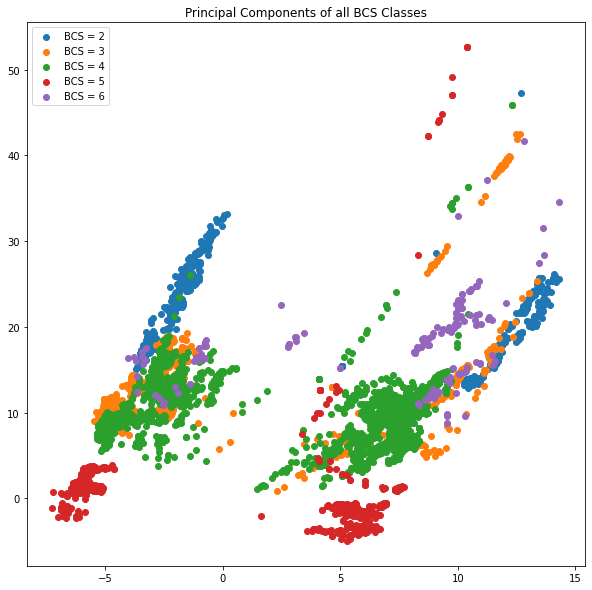

In [71]:
import sklearn.decomposition

pca = sklearn.decomposition.PCA(n_components = 2)

Xn_train2, mx, mn= normalize_Xtrain(X_train2)
Xn_train3, mx, mn= normalize_Xtrain(X_train3)
Xn_train4, mx, mn= normalize_Xtrain(X_train4)
Xn_train5, mx, mn= normalize_Xtrain(X_train5)
Xn_train6, mx, mn= normalize_Xtrain(X_train6)


std_Xn_train2 = std_scale.transform(Xn_train2)
std_Xn_train3 = std_scale.transform(Xn_train3)
std_Xn_train4 = std_scale.transform(Xn_train4)
std_Xn_train5 = std_scale.transform(Xn_train5)
std_Xn_train6 = std_scale.transform(Xn_train6)


two_comp = pca.fit_transform(std_Xn_train)

pca_total = pca.fit(std_Xn_train)
pca_Xn_train2 = pca_total.transform(std_Xn_train2)
pca_Xn_train3 = pca_total.transform(std_Xn_train3)
pca_Xn_train4 = pca_total.transform(std_Xn_train4)
pca_Xn_train5 = pca_total.transform(std_Xn_train5)
pca_Xn_train6 = pca_total.transform(std_Xn_train6)

# print(np.shape(two_comp))

# plt.figure(figsize=(10,10))
# plt.scatter(two_comp[:, 0], two_comp[:, 1])
# plt.title('Principal Components of BCS Features')

plt.figure(figsize=(10,10))
plt.scatter(pca_Xn_train2[:,0], pca_Xn_train2[:,1])
plt.scatter(pca_Xn_train3[:,0], pca_Xn_train3[:,1])
plt.scatter(pca_Xn_train4[:,0], pca_Xn_train4[:,1])
plt.scatter(pca_Xn_train5[:,0], pca_Xn_train5[:,1])
plt.scatter(pca_Xn_train6[:,0], pca_Xn_train6[:,1])
plt.legend(['BCS = 2', 'BCS = 3', 'BCS = 4', 'BCS = 5', 'BCS = 6'])
plt.title('Principal Components of all BCS Classes')

The accuracy is:  0.6680327868852459


C:\Users\zacha\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


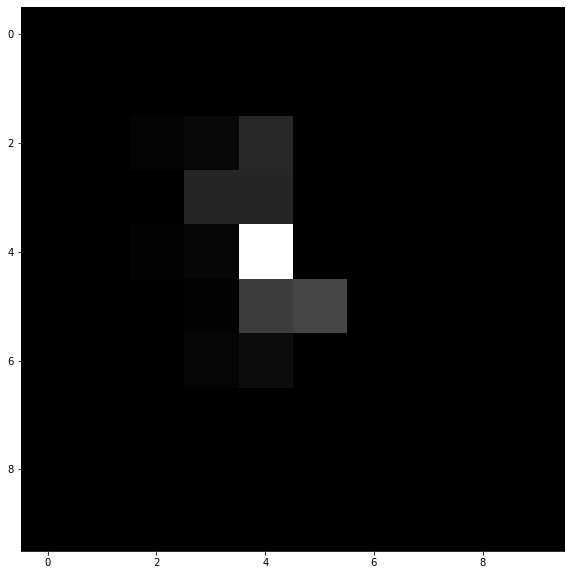

In [72]:
clf=sklearn.svm.SVC(kernel='rbf', gamma = 0.15, C=2, class_weight='balanced')
#clf.class_weight([2, 1, 1, 2])
clf.fit(std_Xn_train,y_train)
y_test_hat=clf.predict(std_Xn_test)
C = sklearn.metrics.confusion_matrix(y_test,y_test_hat,['0','1','2','3','4','5','6','7','8','9'])
acc=np.diag(C).sum().astype(float)/C.sum()

print('The accuracy is: ', acc)

plt.figure(figsize=(10,10))
plt.imshow(C, cmap='gray')

C:\Users\zacha\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


The SVR score is:  -0.1259884959295361


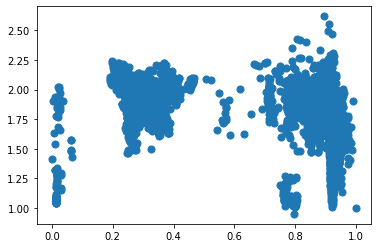

In [21]:
# y_train_reg = []
# for i in range(len(y_train)):
#     if y_train[i] == '4_test':
#         y_train_reg.append(3)
#     if y_train[i] == 'usable':
#         y_train_reg.append(4)

# y_test_reg = []
# for i in range(len(y_test)):
#     if y_test[i] == '4_test':
#         y_test_reg.append(3)
#     if y_test[i] == 'usable':
#         y_test_reg.append(4)


svr = sklearn.svm.SVR(kernel='rbf')
svr.fit(std_Xn_train, y_train)
y_test_hat=svr.predict(std_Xn_test)
score = svr.score(std_Xn_test, y_test)
print('The SVR score is: ', score)

plt.figure()
plt.scatter(Xn_train[::, 0], svr.fit(Xn_train, y_train).predict(Xn_train), s = 50)